In [ ]:
!pip3 install pandas
!pip3 install scipy
!pip3 install scikit-posthocs
!pip3 install matplotlib
!pip3 install seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/pa_analysis

Mounted at /content/gdrive
/content/gdrive/My Drive/pa_analysis


In [1]:
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
demographics = pd.read_csv('pre-preocess-demographics.csv')
demographics = demographics.iloc[:, :11]
demographics = demographics.drop(columns=['SD02_01a', 'SD04_31', 'SD10', 'CASE'])
demographics = demographics.rename(columns={"SD01": "Gender", "SD02_01": "Age", "SD05":"Profession", "SD09":"Studied_Tech?", "SD06": "PA_exp?", "SD04":"mother_tongue"})
demographics.groupby(['RA01', 'Gender']).aggregate(['count', 'mean', 'std'])

Age                      mother_tongue                        \
            count       mean       std         count       mean        std   
RA01 Gender                                                                  
1    1         22  28.409091  7.149153            22  18.954545   8.020671   
     2         39  26.051282  4.723673            39  16.051282   8.242856   
     3          1  24.000000       NaN             1  31.000000        NaN   
2    1         16  26.562500  3.650913            16  18.875000   7.693070   
     2         43  27.930233  5.035093            43  17.627907   9.173002   
3    1         16  27.125000  7.191430            16  19.437500   9.069868   
     2         41  28.073171  6.198348            41  18.536585   8.695107   
4    1         16  30.375000  8.098354            16  16.062500   9.615742   
     2         46  26.652174  4.377810            46  19.565217   9.639392   
5    1         16  26.750000  5.310367            17  19.529412  10.518541   
     2         44  27.113636  6.146339            44  20.136364   8.896278   

            Profession                      Studied_Tech?                      \
                 count       mean       std         count      mean       std   
RA01 Gender                                                                     
1    1              22  14.863636  0.351250            22  1.681818  0.476731   
     2              39  14.820513  0.388776            38  1.815789  0.392859   
     3               1  15.000000       NaN             1  2.000000       NaN   
2    1              16  14.625000  0.500000            16  1.625000  0.500000   
     2              42  14.547619  0.503761            43  1.581395  0.499169   
3    1              16  14.812500  0.403113            16  1.687500  0.478714   
     2              40  14.775000  0.422902            41  1.682927  0.471117   
4    1              16  14.625000  0.500000            16  1.562500  0.512348   
     2              46  14.717391  0.455243            45  1.711111  0.458368   
5    1              16  14.625000  0.500000            16  1.750000  0.447214   
     2              44  14.931818  0.254972            44  1.818182  0.390154   

            PA_exp?                      
              count      mean       std  
RA01 Gender                              
1    1           22  1.272727  0.455842  
     2           39  1.179487  0.388776  
     3            1  2.000000       NaN  
2    1           16  1.125000  0.341565  
     2           43  1.046512  0.213083  
3    1           16  1.187500  0.403113  
     2           41  1.268293  0.448575  
4    1           16  1.062500  0.250000  
     2           46  1.086957  0.284885  
5    1           17  1.352941  0.492592  
     2           44  1.159091  0.369989

In [ ]:
csv_test_scores = pd.read_csv('pre-process2.csv')

csv_test_scores

,PRE_test_score,POST_test_score,RA01
0,10,10,5
1,9,10,5
2,8,9,5
3,8,8,5
4,8,10,5
...,...,...,...
296,10,9,1
297,7,7,1
298,10,10,1
299,9,10,1


In [ ]:
csv_test_scores['ScoreDifference'] = csv_test_scores['POST_test_score'] - csv_test_scores['PRE_test_score']

csv_test_scores

,PRE_test_score,POST_test_score,RA01,ScoreDifference
0,10,10,5,0
1,9,10,5,1
2,8,9,5,1
3,8,8,5,0
4,8,10,5,2
...,...,...,...,...
296,10,9,1,-1
297,7,7,1,0
298,10,10,1,0
299,9,10,1,1


In [ ]:
csv_test_scores.groupby('RA01')[["PRE_test_score", "POST_test_score", "ScoreDifference"]].mean()

,PRE_test_score,POST_test_score,ScoreDifference
RA01,,,
1,8.596774,8.822581,0.225806
2,8.338983,8.677966,0.338983
3,8.491228,8.877193,0.385965
4,8.435484,8.838710,0.403226
5,8.344262,8.934426,0.590164


In [ ]:
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Wilcoxon test is a good alternative to the t-test when the normal distribution of the differences between paired individuals cannot be assumed.


# If p < 0.05, the change from pre-test to post-test within that group is statistically significant.
# If p >= 0.05, the change is not statistically significant.

# 1. Check normality within each group
groups = csv_test_scores['RA01'].unique()
normal_test_results = {}
test_results = {}

for group in groups:
    stat, p_value = shapiro(csv_test_scores[csv_test_scores['RA01'] == group]['ScoreDifference'])
    normal_test_results[group] = p_value
    group_data = csv_test_scores[csv_test_scores['RA01'] == group]
    print(f"Group {group}: p-value for Shapiro-Wilk test = {p_value}")
    if normal_test_results[group] > 0.05: # check significance
        stat, p_value = ttest_rel(group_data['PRE_test_score'], group_data['POST_test_score'])
        test_results[group] = {'test': 'Paired T-Test', 'statistic': stat, 'p-value': p_value}
    else:
        stat, p_value = wilcoxon(group_data['PRE_test_score'], group_data['POST_test_score'])
        test_results[group] = {'test': 'Wilcoxon Signed-Rank Test', 'statistic': stat, 'p-value': p_value}

    print(f"group {group}: {test_results[group]['test']}, p-value = {p_value}")

Group 5: p-value for Shapiro-Wilk test = 3.1337312974362555e-06
group 5: Wilcoxon Signed-Rank Test, p-value = 8.903209345409922e-05
Group 4: p-value for Shapiro-Wilk test = 0.00017534230905492351
group 4: Wilcoxon Signed-Rank Test, p-value = 0.0022973450878172185
Group 3: p-value for Shapiro-Wilk test = 0.00010336264583309308
group 3: Wilcoxon Signed-Rank Test, p-value = 0.007251825693297502
Group 2: p-value for Shapiro-Wilk test = 0.00030842293055672346
group 2: Wilcoxon Signed-Rank Test, p-value = 0.0563729395577693
Group 1: p-value for Shapiro-Wilk test = 1.955730630999451e-06
group 1: Wilcoxon Signed-Rank Test, p-value = 0.04712268823378858


In [ ]:
from scipy.stats import linregress
from scipy.linalg import lstsq


csv2 = pd.read_csv('pre-process2-withevaluation.csv')
csv2 = csv2.drop(['CASE'], axis=1)

emotions = {'happy': 1,
            'neutral': 2,
            'content': 3,
            'frustrated': 4,
            'sad': 5
            }

csv2

,A102_01,A102_02,A102_03,A102_04,A102_05,A102_06,A102_07,A102_08,A102_09,A102_10,...,A105_04,A105_05,E102_01,E102_02,E102_03,E102_04,E102_05,PRE_test_score,POST_test_score,RA01
0,3,2,2,2,4,3,3,4,3,2,...,2,2,1.0,1.0,2.0,3.0,4.0,10,10,5
1,2,3,1,2,4,2,5,5,2,1,...,1,1,NaN,NaN,NaN,NaN,NaN,9,10,5
2,4,4,2,4,4,4,2,4,4,4,...,4,4,2.0,4.0,1.0,3.0,3.0,8,9,5
3,5,5,5,5,5,5,5,5,5,4,...,4,5,NaN,5.0,1.0,1.0,1.0,8,8,5
4,3,3,2,2,4,3,3,4,3,3,...,2,3,1.0,1.0,3.0,4.0,5.0,8,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,4,5,4,2,4,2,2,5,4,3,...,2,4,4.0,5.0,1.0,1.0,1.0,10,9,1
297,3,3,3,4,4,3,4,4,4,2,...,2,1,1.0,1.0,1.0,1.0,1.0,7,7,1
298,5,5,5,5,5,4,5,5,5,5,...,5,5,3.0,4.0,2.0,1.0,1.0,10,10,1
299,3,4,4,5,5,4,4,5,3,2,...,4,5,4.0,3.0,1.0,1.0,1.0,9,10,1


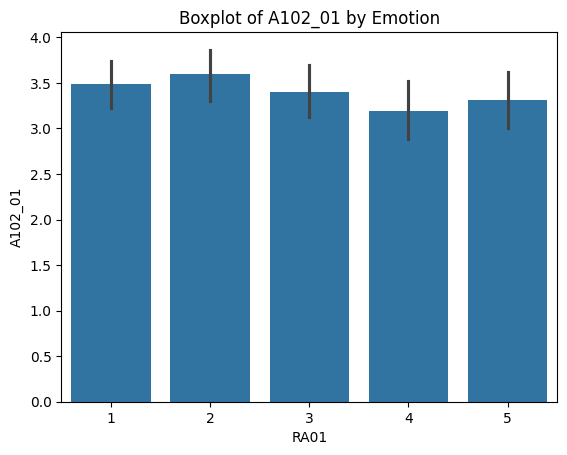

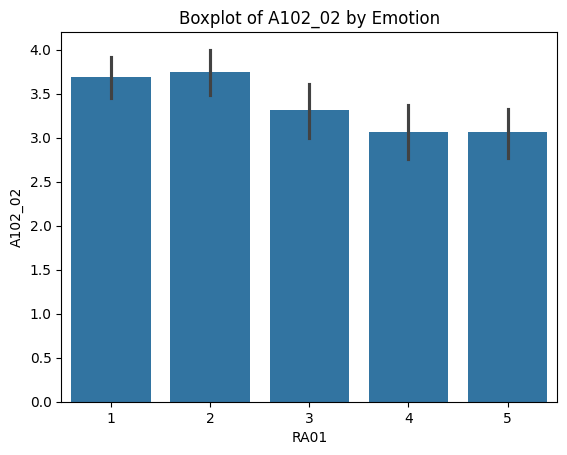

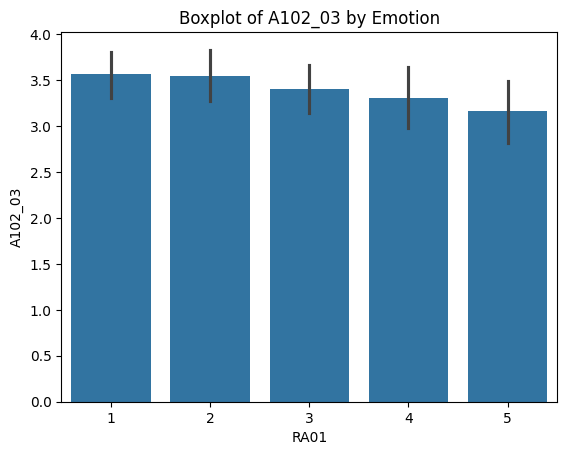

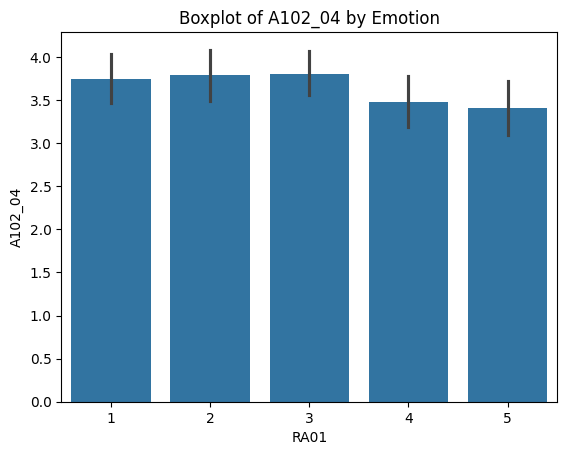

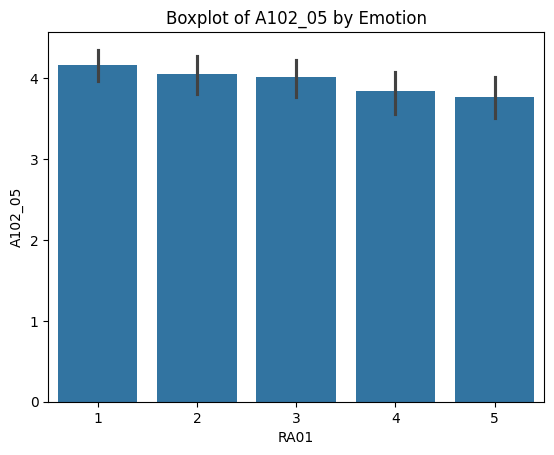

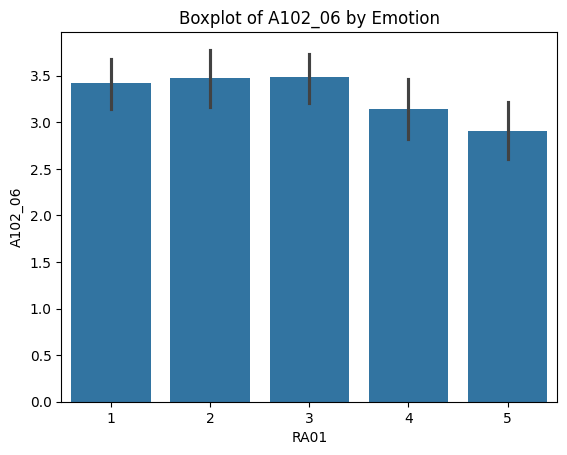

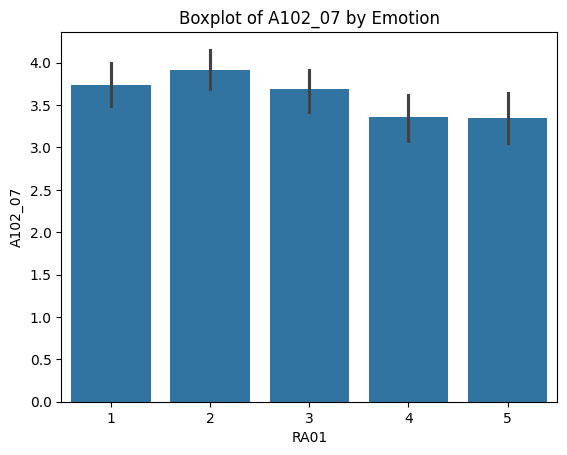

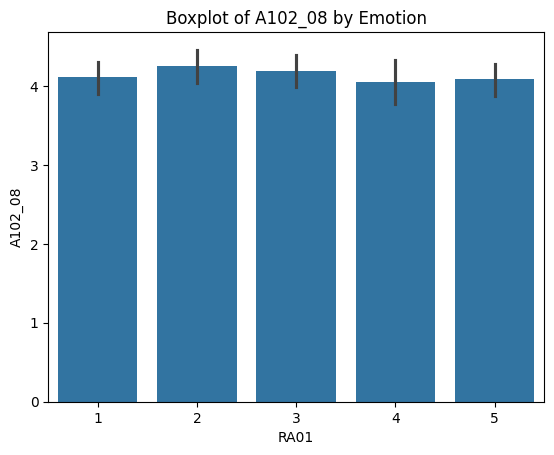

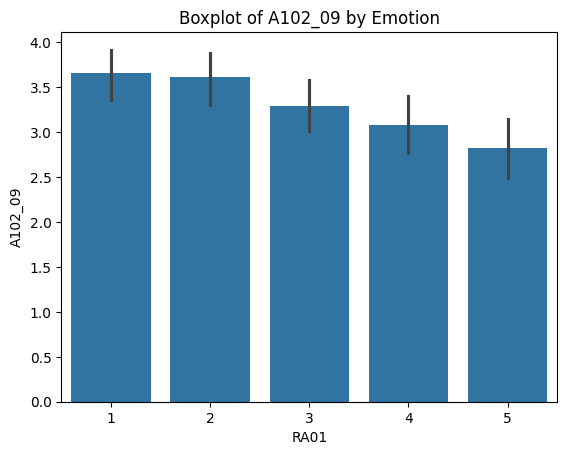

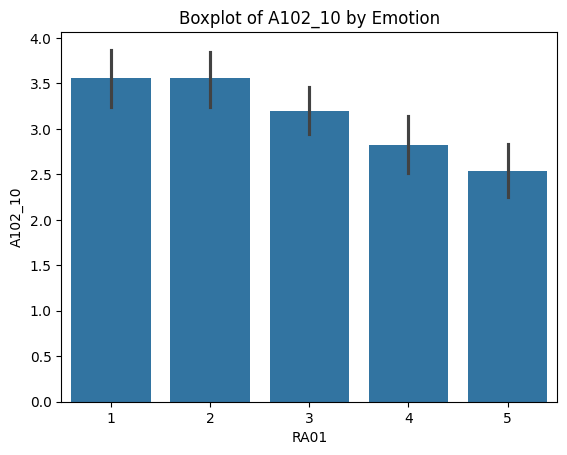

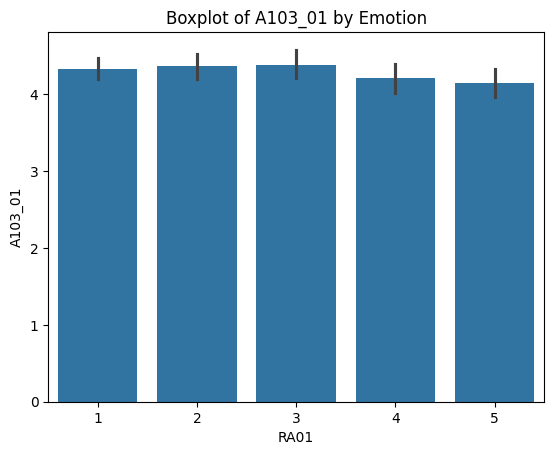

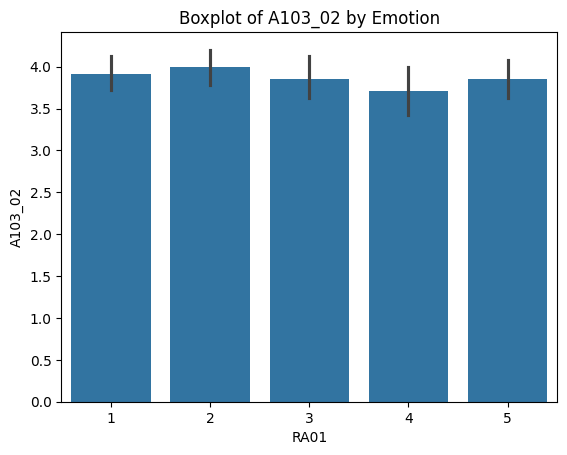

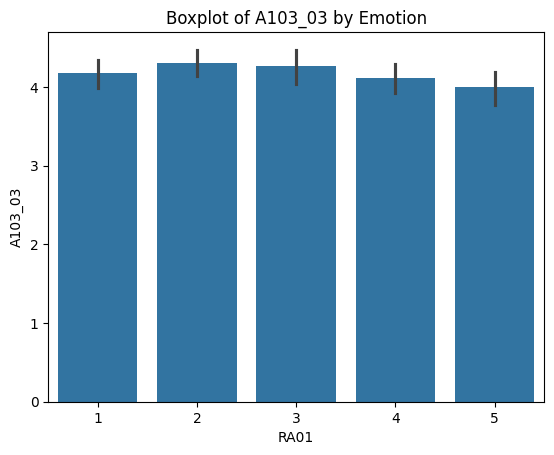

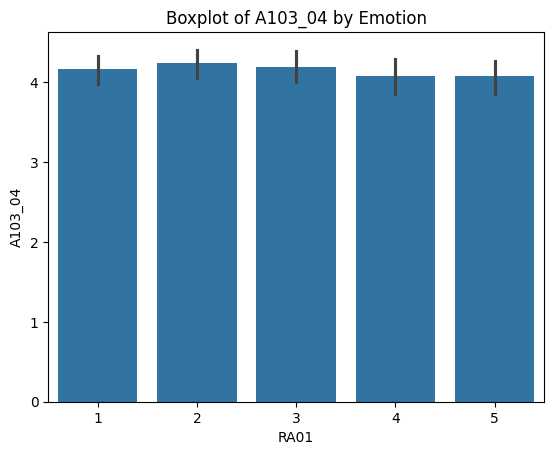

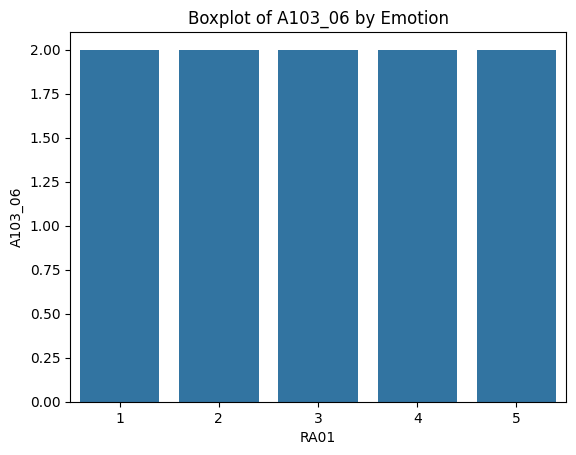

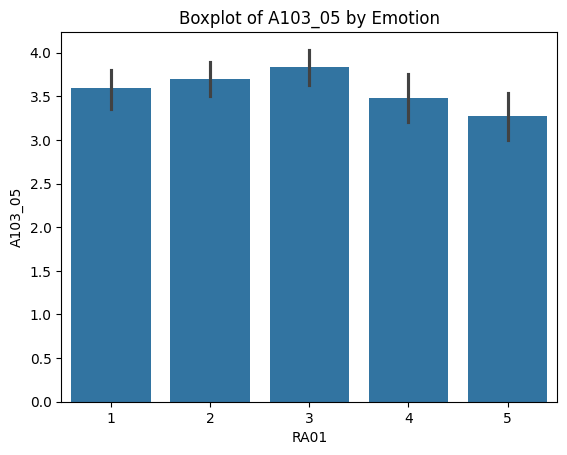

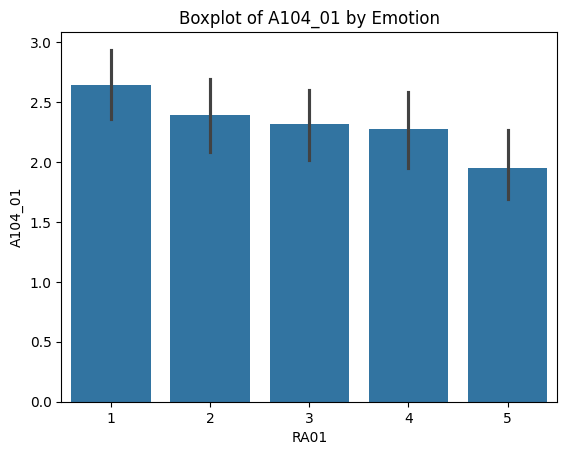

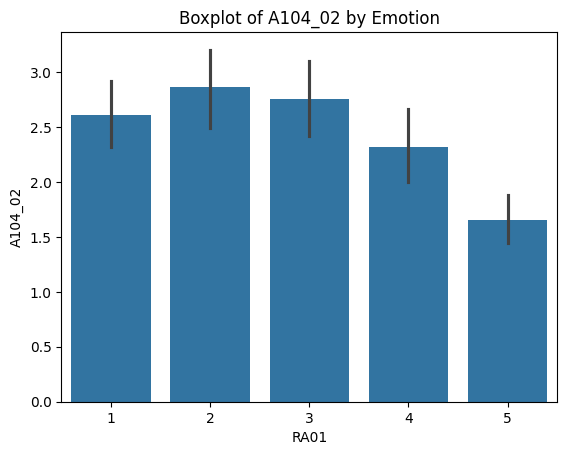

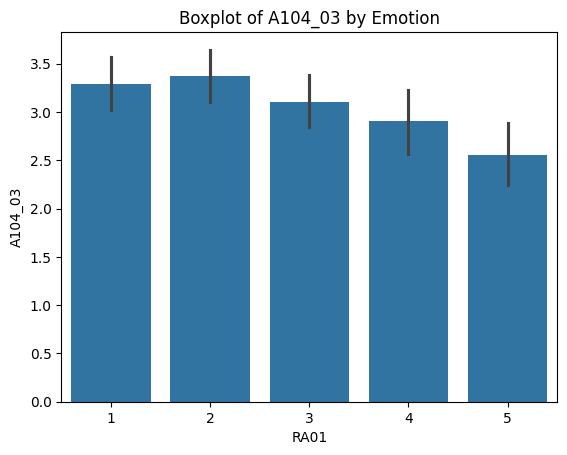

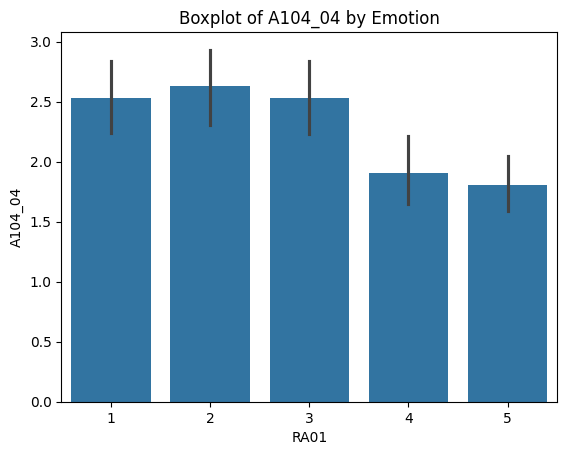

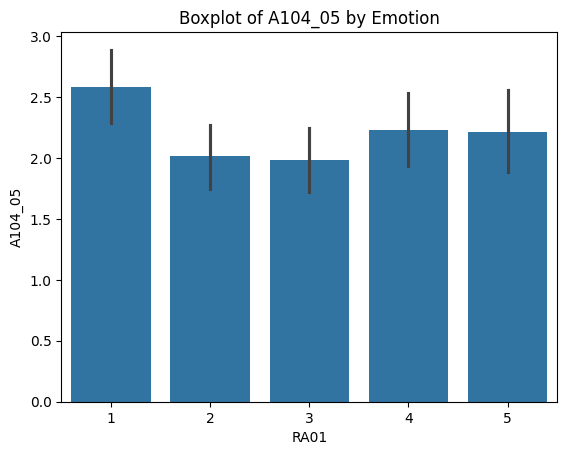

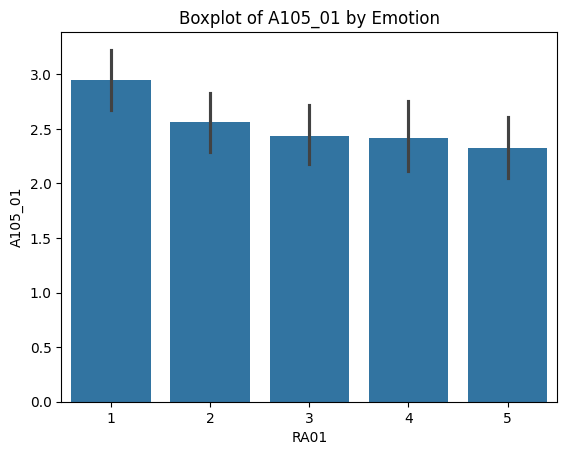

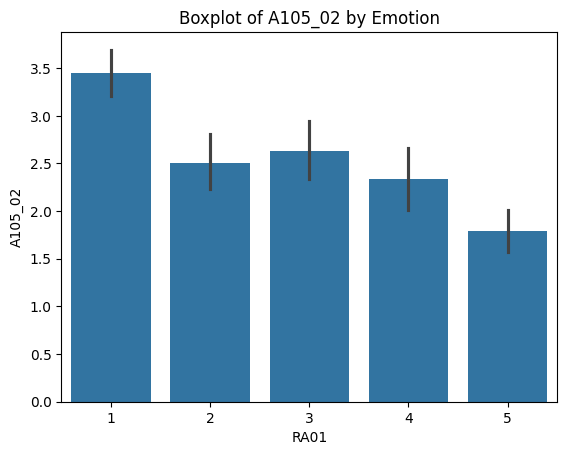

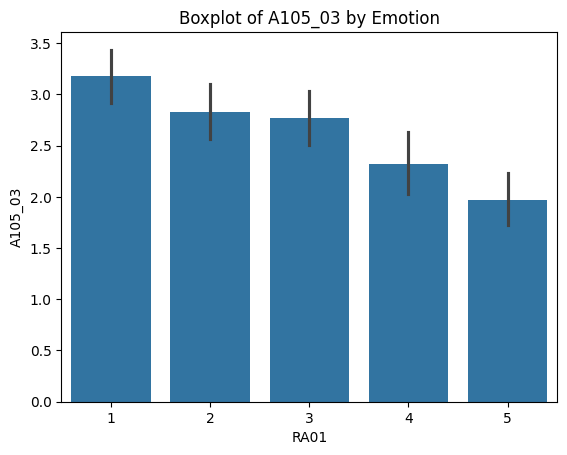

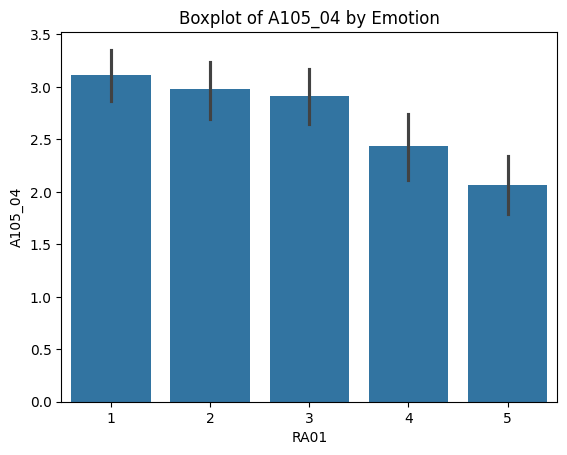

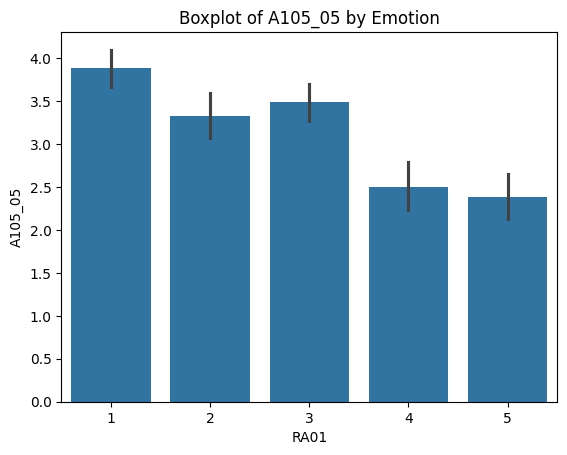

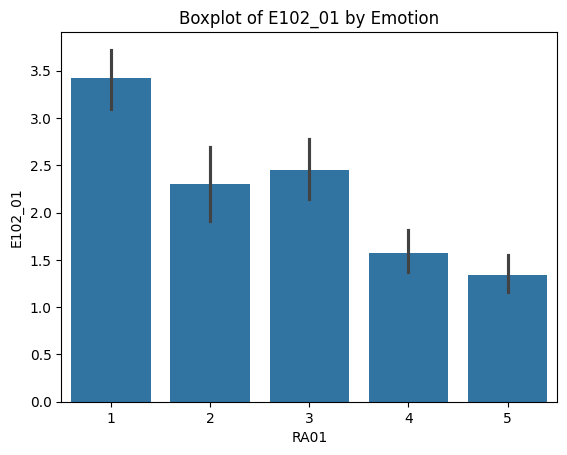

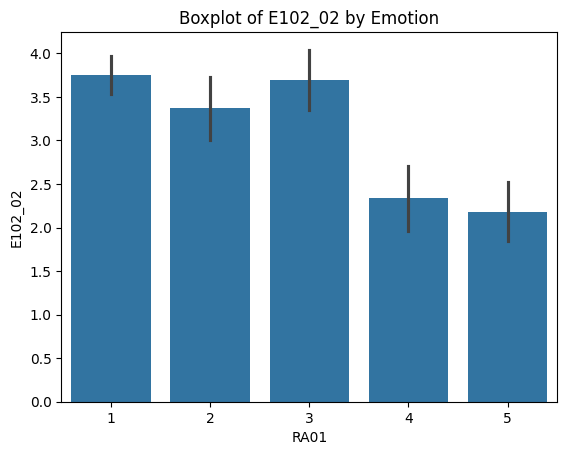

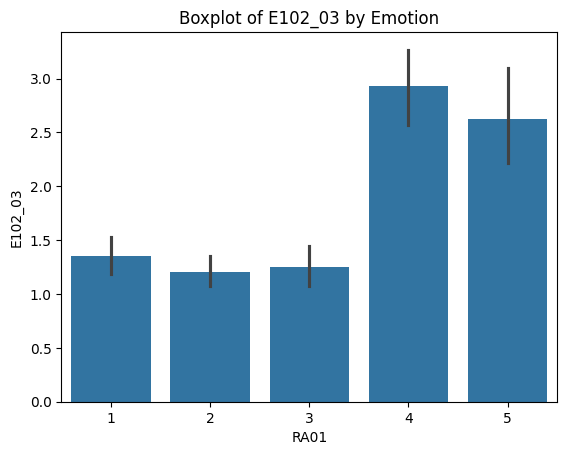

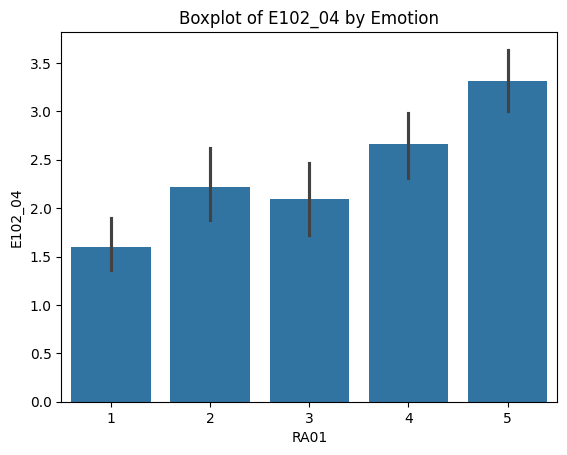

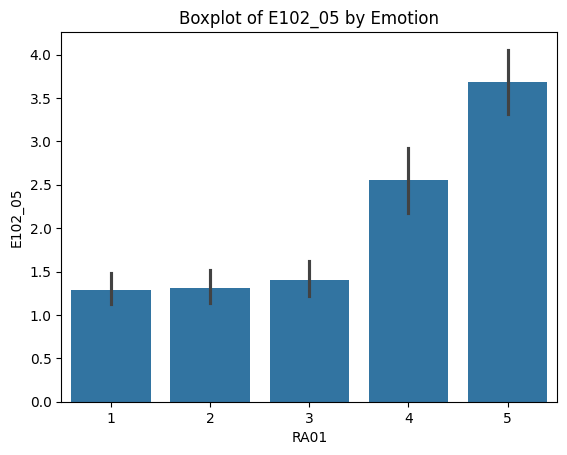

,A102_01,A102_02,A102_03,A102_04,A102_05,A102_06,A102_07,A102_08,A102_09,A102_10,...,transformed_score_A105_01,transformed_score_A105_02,transformed_score_A105_03,transformed_score_A105_04,transformed_score_A105_05,transformed_score_E102_01,transformed_score_E102_02,transformed_score_E102_03,transformed_score_E102_04,transformed_score_E102_05
0,3,2,2,2,4,3,3,4,3,2,...,1.414214,1.414214,1.414214,1.414214,1.414214,1.000000,1.000000,1.414214,1.732051,2.000000
1,2,3,1,2,4,2,5,5,2,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
2,4,4,2,4,4,4,2,4,4,4,...,1.732051,2.000000,2.000000,2.000000,2.000000,1.414214,2.000000,1.000000,1.732051,1.732051
3,5,5,5,5,5,5,5,5,5,4,...,2.000000,2.236068,2.000000,2.000000,2.236068,NaN,2.236068,1.000000,1.000000,1.000000
4,3,3,2,2,4,3,3,4,3,3,...,1.414214,1.414214,1.414214,1.414214,1.732051,1.000000,1.000000,1.732051,2.000000,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,4,5,4,2,4,2,2,5,4,3,...,2.000000,2.000000,2.000000,1.414214,2.000000,2.000000,2.236068,1.000000,1.000000,1.000000
297,3,3,3,4,4,3,4,4,4,2,...,1.000000,1.000000,1.732051,1.414214,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
298,5,5,5,5,5,4,5,5,5,5,...,2.236068,2.236068,2.000000,2.236068,2.236068,1.732051,2.000000,1.414214,1.000000,1.000000
299,3,4,4,5,5,4,4,5,3,2,...,1.732051,2.000000,1.414214,2.000000,2.236068,2.000000,1.732051,1.000000,1.000000,1.000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the evaluation ratings compared among emotion groups, with boxplots
for dep_var in csv2.columns[:31]:  # Assuming first 31 columns are dependent variables
    temp_df = csv2[csv2[y_var].notna()]
    sns.barplot(x='RA01', y=dep_var, data=temp_df)
    plt.title(f'Boxplot of {dep_var} by Emotion')
    plt.show()

csv2

In [ ]:
import numpy as np
from scipy.stats import boxcox

rating_columns = list(csv2.columns.values)[:31]

for rating in rating_columns:
    plt.figure(figsize=(12, 6))  # Set the figure size
    # stat, p = stats.shapiro(csv2[rating])
    # print(f'Shapiro-Wilk Test for {group} on {rating}: Statistic={stat:.3f}, p-value={p:.3f}')
    sns.histplot(csv2, x=rating, bins=10, kde=True, stat="density", alpha=0.5)
    plt.title(f'Histogram of {rating} by Emotion Group')
    plt.xlabel(rating)
    plt.ylabel('Density')
    plt.legend(title='Group')
    plt.show()

    # transform data version
    # csv2[f"transformed_score_{rating}"] = np.sqrt(csv2[rating])
    csv2[f"transformed_score_{rating}"], _ = boxcox(csv2[rating])
    sns.histplot(csv2, x=f"transformed_score_{rating}", bins=10, kde=True, stat="density", alpha=0.5)
    plt.title(f'Histogram of transformed_score_{rating} by Emotion Group')
    plt.xlabel(f"transformed_score_{rating}")
    plt.ylabel('Density')
    plt.legend(title='Group')
    plt.show()

In [ ]:
# check if the evaluation ratings are in a normal distribution in each emotion group
# if yes, use ANOVA
# if no, use Kruskal-Wallis (ANOVA equivilent for non-parametric test)
from scipy import stats

rating_columns = list(csv2.columns.values)[:31]
groups = csv2['RA01'].unique()

for rating in rating_columns:
    plt.figure(figsize=(12, 6))  # Set the figure size
    for group in groups:
        stat, p = stats.shapiro(csv2[csv2['RA01'] == group][f"transformed_score_{rating}"])
        print(f'Shapiro-Wilk Test for {group} on {rating}: Statistic={stat:.3f}, p-value={p:.3f}')
        sns.histplot(csv2[csv2['RA01'] == group], x=f"transformed_score_{rating}", bins=10, kde=True, label=group, stat="density", alpha=0.5)

        plt.title(f'Histogram of {rating} by Emotion ${group}')
        plt.xlabel(rating)
        plt.ylabel('Density')
        plt.legend(title='Group')
        plt.show()

In [ ]:
# can participants recognise the intended emotions
# test: is there a significant difference in the rating for {emotion} in {emotion} video?

# Define the independent variables and dependent ordinal variable
from scipy.stats import friedmanchisquare

y_variables = csv2.columns[:10]
groups = csv2['RA01'].unique()
emotion_recognition_columns = list(csv2.columns.values)[26:31]


for group in groups:
    temp_df = csv2[csv2['RA01'] == group]
    temp_df = temp_df[emotion_recognition_columns].dropna()
    ratings = [temp_df[col].values for col in emotion_recognition_columns]
    if len(ratings) > 1 and all(len(rating) == len(ratings[0]) for rating in ratings):
        stat, p = friedmanchisquare(*ratings)
        print(f'Friedman Test for {group}: Statistic={stat:.3f}, p-value={p}')
    else:
        print(f'Skipping {group} due to unequal or insufficient data in ratings')



Friedman Test for 5: Statistic=61.324, p-value=1.5282854543135847e-12
Friedman Test for 4: Statistic=29.688, p-value=5.6657449762876705e-06
Friedman Test for 3: Statistic=80.654, p-value=1.2658338495153252e-16
Friedman Test for 2: Statistic=62.582, p-value=8.310671683685243e-13
Friedman Test for 1: Statistic=125.394, p-value=3.7595517877566304e-26


Wilcoxon test with zero-method "Pratt": Opt for this when you want to include all data points in the ranking process but remain conservative about zeros impacting the results.

In [ ]:
from itertools import combinations
from scipy.stats import wilcoxon

# Perform pairwise emotions between the rating columns within this group
# for col1, col2 in combinations(emotion_recognition_columns, 2):
for i in range(len(emotion_recognition_columns)):
    target_emotion_rating = emotion_recognition_columns[i]
    for j in range(len(emotion_recognition_columns)):
        if i == j:
            continue
        nontarget_emotion_rating = emotion_recognition_columns[j]
    # Wilcoxon signed-rank test between each pair
        temp_df = csv2[csv2['RA01'] == 5]
        temp_df = temp_df[emotion_recognition_columns].dropna()

        rating_1 = temp_df[target_emotion_rating]
        rating_2 = temp_df[nontarget_emotion_rating]

        # differences = [x for x in list(rating_1 - rating_2) if x != 0]
        differences = rating_1 - rating_2
        # print(differences, method='approx')
        # # stat, p = wilcoxon(rating_1, rating_2)
        stat, p = wilcoxon(differences, alternative= 'greater', method='approx', zero_method='pratt')
        print("stat = " , stat)
        rank_df = pd.DataFrame({'differences': differences})

        # Drop zero differences and calculate ranks for non-zero differences
        # rank_df = rank_df[rank_df['differences'] != 0]
        rank_df['absolute_diff'] = rank_df['differences'].abs()
        rank_df['rank'] = rank_df['absolute_diff'].rank()

        # Assign positive or negative ranks
        rank_df['rank_sign'] = rank_df['differences'].apply(lambda x: 'Positive' if x > 0 else 'Equal' if x == 0 else 'Negative')

        # Separate positive and negative ranks
        positive_ranks = rank_df[rank_df['rank_sign'] == 'Positive']['rank'].sum()
        negative_ranks = rank_df[rank_df['rank_sign'] == 'Negative']['rank'].sum()
        positive_count = rank_df[rank_df['rank_sign'] == 'Positive'].shape[0]
        negative_count = rank_df[rank_df['rank_sign'] == 'Negative'].shape[0]
        equal_count = rank_df[rank_df['rank_sign'] == 'Equal'].shape[0]
        # Calculate the average ranks for positive and negative
        average_positive_rank = rank_df[rank_df['rank_sign'] == 'Positive']['rank'].mean() if positive_count > 0 else 0
        average_negative_rank = rank_df[rank_df['rank_sign'] == 'Negative']['rank'].mean() if negative_count > 0 else 0

        print(f'Wilcoxon Statistic: {stat}, p-value: {p}')
        print(f'Sum of Positive Ranks: {positive_ranks}')
        print(f'Sum of Negative Ranks: {negative_ranks}')
        print(f'Count of positive, negative, Equal Differences: {positive_count}, {negative_count}, {equal_count}')
        print(f'avaerage positive, negative rank: {average_positive_rank}, {average_negative_rank}')
        print("-----")
        print(f'Comparison between {target_emotion_rating} and {nontarget_emotion_rating}: Statistic={stat}, p-value={p:.3f}')
        print("-----------")

stat =  86.0
Wilcoxon Statistic: 86.0, p-value: 0.9997735808321004
Sum of Positive Ranks: 86.0
Sum of Negative Ranks: 629.0
Count of positive, negative, Equal Differences: 3, 19, 21
avaerage positive, negative rank: 28.666666666666668, 33.10526315789474
-----
Comparison between E102_01 and E102_02: Statistic=86.0, p-value=1.000
-----------
stat =  135.0
Wilcoxon Statistic: 135.0, p-value: 0.9999244311475212
Sum of Positive Ranks: 135.0
Sum of Negative Ranks: 756.0
Count of positive, negative, Equal Differences: 7, 26, 10
avaerage positive, negative rank: 19.285714285714285, 29.076923076923077
-----
Comparison between E102_01 and E102_03: Statistic=135.0, p-value=1.000
-----------
stat =  40.0
Wilcoxon Statistic: 40.0, p-value: 0.9999998844273069
Sum of Positive Ranks: 40.0
Sum of Negative Ranks: 891.0
Count of positive, negative, Equal Differences: 2, 36, 5
avaerage positive, negative rank: 20.0, 24.75
-----
Comparison between E102_01 and E102_04: Statistic=40.0, p-value=1.000
--------

### in happy video, happy emotion rating compared to:
| emotion                     | Wilcoxon Statistic | p-value       | Sum of Positive Ranks | Sum of Negative Ranks | Count of Positive | Count of Negative | Count of Equal | Avg. Positive Rank | Avg. Negative Rank |
|--------------------------------|--------------------|---------------|-----------------------|-----------------------|-------------------|-------------------|----------------|---------------------|---------------------|
| content           | 318.0              | 0.952         | 318.0                 | 627.0                 | 9                 | 18                | 21             | 35.33               | 34.83               |
| frustrated           | 1100.5             | <0.001        | 1100.5                | 39.5                  | 37                | 3                 | 8              | 29.74               | 13.17               |
| bored           | 1060.0             | <0.001        | 1060.0                | 88.0                  | 37                | 4                 | 7              | 28.65               | 22.00               |
| sad           | 1120.0             | <0.001        | 1120.0                | 35.0                  | 40                | 2                 | 6              | 28.00               | 17.50               |



### in content video, content emotion rating compared to:

| emotion                     | Wilcoxon Statistic | p-value       | Sum of Positive Ranks | Sum of Negative Ranks | Count of Positive | Count of Negative | Count of Equal | Avg. Positive Rank | Avg. Negative Rank |
|--------------------------------|--------------------|---------------|-----------------------|-----------------------|-------------------|-------------------|----------------|---------------------|---------------------|
|  happy           | 625.0             | <0.001        | 625.0                 | 24.0                  | 21                | 1                 | 18             | 29.76               | 24.0                |
|  frustrated            | 784.0             | <0.001        | 784.0                 | 0.0                   | 32                | 0                 | 8              | 24.50               | 0.0                 |
|  bored            | 722.0             | <0.001        | 722.0                 | 83.0                  | 30                | 5                 | 5              | 24.07               | 16.6                |
|  sad            | 781.5             | <0.001        | 781.5                 | 10.5                  | 32                | 1                 | 7              | 24.42               | 10.5                |


### in frustrated video, frustrated emotion rating compared to:

| emotion                     | Wilcoxon Statistic | p-value       | Sum of Positive Ranks | Sum of Negative Ranks | Count of Positive | Count of Negative | Count of Equal | Avg. Positive Rank | Avg. Negative Rank |
|--------------------------------|--------------------|---------------|-----------------------|-----------------------|-------------------|-------------------|----------------|---------------------|---------------------|
|  happy           | 666.0             | <0.001        | 666.0                 | 104.0                 | 28                | 7                 | 4              | 23.79               | 14.86               |
|  content            | 575.5             | 0.004         | 575.5                 | 194.5                 | 24                | 11                | 4              | 23.98               | 17.68               |
|  bored            | 496.0             | 0.015         | 496.0                 | 193.0                 | 19                | 7                 | 13             | 26.11               | 27.57               |
|  sad            | 506.0             | 0.017         | 506.0                 | 208.0                 | 18                | 10                | 11             | 28.11               | 20.80               |


### in sad video, sad emotion rating compared to:
| emotion                     | Wilcoxon Statistic | p-value       | Sum of Positive Ranks | Sum of Negative Ranks | Count of Positive | Count of Negative | Count of Equal | Avg. Positive Rank | Avg. Negative Rank |
|--------------------------------|--------------------|---------------|-----------------------|-----------------------|-------------------|-------------------|----------------|---------------------|---------------------|
|  happy            | 892.5             | <0.001        | 892.5                 | 32.5                  | 35                | 2                 | 6              | 25.5                | 16.25               |
|  content            | 799.0             | <0.001        | 799.0                 | 132.0                 | 29                | 9                 | 5              | 27.55               | 14.67               |
| frustrated            | 733.0             | <0.001        | 733.0                 | 122.0                 | 26                | 4                 | 13             | 28.19               | 30.5                |
| bored            | 547.5             | 0.058         | 547.5                 | 293.5                 | 18                | 11                | 14             | 30.42               | 26.68               |


### faciliate learning rating

In [ ]:
csv2.groupby('RA01').aggregate(['mean', 'std']).iloc[:, :20]

A102_01             A102_02             A102_03             A102_04  \
          mean       std      mean       std      mean       std      mean   
RA01                                                                         
1     3.483871  1.003958  3.693548  0.951077  3.564516  1.065417  3.741935   
2     3.593220  1.146489  3.745763  1.027102  3.542373  1.087896  3.796610   
3     3.403509  1.147352  3.315789  1.227045  3.403509  1.099670  3.807018   
4     3.193548  1.278302  3.064516  1.199330  3.306452  1.325521  3.483871   
5     3.311475  1.285055  3.065574  1.108585  3.163934  1.293320  3.409836   

                 A102_05             A102_06             A102_07            \
           std      mean       std      mean       std      mean       std   
RA01                                                                         
1     1.144273  4.161290  0.750815  3.419355  1.124225  3.741935  1.085455   
2     1.185831  4.050847  0.936312  3.474576  1.208532  3.915254  0.970036   
3     1.025367  4.017544  0.896247  3.491228  1.071094  3.684211  0.966546   
4     1.197565  3.838710  1.074191  3.145161  1.303800  3.354839  1.160791   
5     1.256676  3.770492  1.039125  2.901639  1.261017  3.344262  1.209480   

       A102_08             A102_09             A102_10            
          mean       std      mean       std      mean       std  
RA01                                                              
1     4.112903  0.851322  3.661290  1.172688  3.564516  1.223017  
2     4.254237  0.862898  3.610169  1.144958  3.559322  1.235554  
3     4.192982  0.811493  3.298246  1.117473  3.192982  1.025367  
4     4.048387  1.092859  3.080645  1.321926  2.822581  1.299738  
5     4.081967  0.842518  2.819672  1.258414  2.540984  1.177197

### credibility rating

In [ ]:
csv2.groupby('RA01').aggregate(['mean', 'std']).iloc[:, 20:32]

A103_01             A103_02             A103_03             A103_04  \
          mean       std      mean       std      mean       std      mean   
RA01                                                                         
1     4.322581  0.566097  3.919355  0.795446  4.177419  0.713435  4.161290   
2     4.372881  0.640536  4.000000  0.870988  4.305085  0.676049  4.237288   
3     4.385965  0.725908  3.859649  0.934241  4.263158  0.835086  4.192982   
4     4.209677  0.771141  3.709677  1.092254  4.112903  0.770455  4.080645   
5     4.147541  0.703232  3.852459  0.872469  4.000000  0.836660  4.081967   

               A103_06        A103_05            
           std    mean  std      mean       std  
RA01                                             
1     0.682175     2.0  0.0  3.596774  0.948851  
2     0.727276     2.0  0.0  3.694915  0.814825  
3     0.789181     2.0  0.0  3.842105  0.797081  
4     0.855041     2.0  0.0  3.483871  1.112403  
5     0.759278     2.0  0.0  3.278689  1.097439

### human-like rating

In [ ]:
csv2.groupby('RA01').aggregate(['mean', 'std']).iloc[:, 32:42]

A104_01             A104_02             A104_03             A104_04  \
          mean       std      mean       std      mean       std      mean   
RA01                                                                         
1     2.645161  1.146581  2.612903  1.219444  3.290323  1.107161  2.532258   
2     2.389831  1.174689  2.864407  1.395283  3.372881  1.096991  2.627119   
3     2.315789  1.120553  2.754386  1.379450  3.105263  1.112979  2.526316   
4     2.274194  1.243598  2.322581  1.364349  2.903226  1.302075  1.903226   
5     1.950820  1.116934  1.655738  0.928893  2.557377  1.271804  1.803279   

                 A104_05            
           std      mean       std  
RA01                                
1     1.210849  2.580645  1.208554  
2     1.258054  2.016949  1.008439  
3     1.240755  1.982456  0.972685  
4     1.169415  2.225806  1.233672  
5     0.945510  2.213115  1.305307

### engaging rating

In [ ]:
csv2.groupby('RA01').aggregate(['mean', 'std']).iloc[:, 42:52]

A105_01             A105_02             A105_03             A105_04  \
          mean       std      mean       std      mean       std      mean   
RA01                                                                         
1     2.951613  1.107758  3.451613  1.002904  3.177419  1.016651  3.112903   
2     2.559322  1.087090  2.508475  1.194425  2.830508  1.052952  2.983051   
3     2.438596  1.085909  2.631579  1.219361  2.771930  1.052506  2.912281   
4     2.419355  1.287371  2.338710  1.342173  2.322581  1.170319  2.435484   
5     2.327869  1.150671  1.786885  0.968069  1.967213  0.982636  2.065574   

                 A105_05            
           std      mean       std  
RA01                                
1     1.072837  3.887097  0.889001  
2     1.121752  3.322034  0.990310  
3     1.022614  3.491228  0.847745  
4     1.262589  2.500000  1.155883  
5     1.152806  2.377049  1.035438

### emotion ratings

In [ ]:
csv2.groupby('RA01').aggregate(['mean', 'std']).iloc[:, 52:62]

E102_01             E102_02             E102_03             E102_04  \
          mean       std      mean       std      mean       std      mean   
RA01                                                                         
1     3.425926  1.159080  3.750000  0.858116  1.350000  0.708902  1.603448   
2     2.304348  1.314358  3.372549  1.341056  1.203704  0.562328  2.220000   
3     2.448980  1.119174  3.693878  1.261680  1.250000  0.710565  2.098039   
4     1.574074  0.837829  2.333333  1.405770  2.928571  1.425191  2.666667   
5     1.339286  0.720525  2.173077  1.294349  2.627451  1.611965  3.309091   

                 E102_05            
           std      mean       std  
RA01                                
1     1.075071  1.285714  0.706188  
2     1.389318  1.307692  0.755073  
3     1.284600  1.400000  0.782461  
4     1.259630  2.549020  1.346309  
5     1.303453  3.685185  1.384879

In [ ]:
csv3 = csv2.iloc[:, 1:34]
csv3

,A102_02,A102_03,A102_04,A102_05,A102_06,A102_07,A102_08,A102_09,A102_10,A103_01,...,A105_04,A105_05,E102_01,E102_02,E102_03,E102_04,E102_05,PRE_test_score,POST_test_score,RA01
0,2,2,2,4,3,3,4,3,2,4,...,2,2,1.0,1.0,2.0,3.0,4.0,10,10,5
1,3,1,2,4,2,5,5,2,1,5,...,1,1,NaN,NaN,NaN,NaN,NaN,9,10,5
2,4,2,4,4,4,2,4,4,4,4,...,4,4,2.0,4.0,1.0,3.0,3.0,8,9,5
3,5,5,5,5,5,5,5,5,4,5,...,4,5,NaN,5.0,1.0,1.0,1.0,8,8,5
4,3,2,2,4,3,3,4,3,3,4,...,2,3,1.0,1.0,3.0,4.0,5.0,8,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5,4,2,4,2,2,5,4,3,4,...,2,4,4.0,5.0,1.0,1.0,1.0,10,9,1
297,3,3,4,4,3,4,4,4,2,4,...,2,1,1.0,1.0,1.0,1.0,1.0,7,7,1
298,5,5,5,5,4,5,5,5,5,5,...,5,5,3.0,4.0,2.0,1.0,1.0,10,10,1
299,4,4,5,5,4,4,5,3,2,4,...,4,5,4.0,3.0,1.0,1.0,1.0,9,10,1


### ratings on the instructor's performance

#### comparison - facilitating learning

In [ ]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

facilitate_rating = list(csv2.columns.values[:10])

for rating in facilitate_rating:
    rating_per_group_list = [csv2[csv2['RA01'] == n][rating].dropna() for n in csv2['RA01'].unique()]
    h_stat, p_value = kruskal(*rating_per_group_list)
    print(f"Rating: {rating} | H-statistic: {h_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        list_of_values = [n.values for n in rating_per_group_list]
        p = posthoc_dunn(list_of_values, p_adjust='holm')
        print(p)


Rating: A102_01 | H-statistic: 3.2658, p-value: 0.5144
Rating: A102_02 | H-statistic: 18.7271, p-value: 0.0009
          1         2         3         4         5
1  1.000000  1.000000  0.728695  0.013477  0.021416
2  1.000000  1.000000  0.728695  0.017435  0.026571
3  0.728695  0.728695  1.000000  0.404922  0.535318
4  0.013477  0.017435  0.404922  1.000000  1.000000
5  0.021416  0.026571  0.535318  1.000000  1.000000
Rating: A102_03 | H-statistic: 3.7358, p-value: 0.4429
Rating: A102_04 | H-statistic: 5.5943, p-value: 0.2316
Rating: A102_05 | H-statistic: 5.2432, p-value: 0.2632
Rating: A102_06 | H-statistic: 9.2051, p-value: 0.0562
Rating: A102_07 | H-statistic: 10.6848, p-value: 0.0303
          1         2    3         4        5
1  1.000000  1.000000  1.0  0.094687  0.43176
2  1.000000  1.000000  1.0  0.094687  0.43176
3  1.000000  1.000000  1.0  1.000000  1.00000
4  0.094687  0.094687  1.0  1.000000  1.00000
5  0.431760  0.431760  1.0  1.000000  1.00000
Rating: A102_08 | H-stati

####   comparison - credibility

In [ ]:
credible = list(csv2.columns.values[10:16])

for rating in credible:
    rating_per_group_list = [csv2[csv2['RA01'] == n][rating].dropna() for n in csv2['RA01'].unique()]
    try:
        h_stat, p_value = kruskal(*rating_per_group_list)
        print(f"Rating: {rating} | H-statistic: {h_stat:.4f}, p-value: {p_value:.4f}")
        if p_value < 0.05:
            list_of_values = [n.values for n in rating_per_group_list]
            p = posthoc_dunn(list_of_values, p_adjust='holm')
            print(p)
    except Exception:
        continue

Rating: A103_01 | H-statistic: 6.1768, p-value: 0.1863
Rating: A103_02 | H-statistic: 2.0159, p-value: 0.7328
Rating: A103_03 | H-statistic: 6.6545, p-value: 0.1553
Rating: A103_04 | H-statistic: 1.9711, p-value: 0.7411
Rating: A103_05 | H-statistic: 8.8178, p-value: 0.0658


#### comparison - engagedness

In [ ]:
human_like = list(csv2.columns.values[16:21])

for rating in human_like:
    rating_per_group_list = [csv2[csv2['RA01'] == n][rating].dropna() for n in csv2['RA01'].unique()]
    h_stat, p_value = kruskal(*rating_per_group_list)
    print(f"Rating: {rating} | H-statistic: {h_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        list_of_values = [n.values for n in rating_per_group_list]
        p = posthoc_dunn(list_of_values, p_adjust='holm')
        print(p)

Rating: A104_01 | H-statistic: 13.4013, p-value: 0.0095
          1         2         3         4         5
1  1.000000  0.694080  0.367281  0.218592  0.003413
2  0.694080  1.000000  1.000000  1.000000  0.328671
3  0.367281  1.000000  1.000000  1.000000  0.694080
4  0.218592  1.000000  1.000000  1.000000  0.788191
5  0.003413  0.328671  0.694080  0.788191  1.000000
Rating: A104_02 | H-statistic: 33.5220, p-value: 0.0000
          1         2         3         4         5
1  1.000000  0.037066  0.000048  0.000006  0.000130
2  0.037066  1.000000  0.338708  0.144157  0.504645
3  0.000048  0.338708  1.000000  1.000000  1.000000
4  0.000006  0.144157  1.000000  1.000000  1.000000
5  0.000130  0.504645  1.000000  1.000000  1.000000
Rating: A104_03 | H-statistic: 16.7600, p-value: 0.0022
          1         2         3         4         5
1  1.000000  0.585664  0.174282  0.002723  0.011390
2  0.585664  1.000000  1.000000  0.253687  0.585664
3  0.174282  1.000000  1.000000  0.769554  1.000000


#### comparison - human-like-ness

In [ ]:
engaging = list(csv2.columns.values[21:26])

for rating in engaging:
    rating_per_group_list = [csv2[csv2['RA01'] == n][rating].dropna() for n in csv2['RA01'].unique()]
    h_stat, p_value = kruskal(*rating_per_group_list)
    print(f"Rating: {rating} | H-statistic: {h_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        list_of_values = [n.values for n in rating_per_group_list]
        p = posthoc_dunn(list_of_values, p_adjust='holm')
        print(p) # p is pd.DataFrame type


Rating: A105_01 | H-statistic: 11.5200, p-value: 0.0213
          1         2         3         4         5
1  1.000000  1.000000  1.000000  1.000000  0.024505
2  1.000000  1.000000  1.000000  1.000000  0.062546
3  1.000000  1.000000  1.000000  1.000000  0.136438
4  1.000000  1.000000  1.000000  1.000000  0.495878
5  0.024505  0.062546  0.136438  0.495878  1.000000
Rating: A105_02 | H-statistic: 59.0392, p-value: 0.0000
              1         2         3         4             5
1  1.000000e+00  0.068946  0.000928  0.004209  7.473765e-13
2  6.894635e-02  1.000000  0.403884  0.643881  2.771841e-06
3  9.277159e-04  0.403884  1.000000  0.643881  2.651346e-03
4  4.208680e-03  0.643881  0.643881  1.000000  3.856354e-04
5  7.473765e-13  0.000003  0.002651  0.000386  1.000000e+00
Rating: A105_03 | H-statistic: 44.5973, p-value: 0.0000
              1         2         3         4             5
1  1.000000e+00  0.299460  0.000603  0.000154  2.150532e-08
2  2.994599e-01  1.000000  0.095858  0.0